Imports and upload small dataset scanned from Wikipedia (100 MB)


In [0]:
import gzip
import gensim 
import logging
import pandas as pd
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import Word2Vec
from google.colab import files
import sys
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


In [0]:
data_file='enwiki-latest-abstract1.xml.gz'

Compute lose after each epoch function

In [0]:
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss


The function that processing and cleaning the file and return a list of words for every line - This method reads the input file which is in gzip format - 

In [ ]:
documents = list (read_input (data_file))
logging.info ("Done reading data file")

In [0]:
def read_input(input_file):
    """"""
    
    logging.info("reading file {0}...this may take a while".format(input_file))
    
    with gzip.open (input_file, 'rb') as f:
        for i, line in enumerate (f): 

            if (i%10000==0):
                logging.info ("read {0} sentences".format (i))

            # do some pre-processing and return a list of words for each sentence of the text
            yield gensim.utils.simple_preprocess (line)

read the tokenized lines into a list,
each line item becomes a series of words
so this becomes a list of lists

In [ ]:
documents = list (read_input (data_file))
logging.info ("Done reading data file")

Training the model with the parameters :  Dimensionality of the word vectors : 150, 
Maximum distance between the current and predicted word within a sentence: 10 ,  Ignores all words with total frequency lower than : 2, Training algorithm - Cbow , Accelerator : Negative Sampling, number of epochs = 4 (enough for loss = 0)

In [ ]:
model = gensim.models.Word2Vec (documents, size=150, window=9, min_count=2, workers=10,sg = 0, hs =0,compute_loss=True, callbacks=[callback()] )
model.train(documents,total_examples=len(documents),epochs=4)


Model latest loss:

In [7]:
model.get_latest_training_loss()


0.0

Top 10 similar words to the word "king"




In [8]:
w1 = "king"
model.wv.most_similar (positive=w1)

2020-05-11 09:39:53,504 : INFO : precomputing L2-norms of word weight vectors


[('prince', 0.6867810487747192),
 ('kings', 0.6809967756271362),
 ('queen', 0.6687802672386169),
 ('regent', 0.6139390468597412),
 ('vi', 0.609061062335968),
 ('consort', 0.6089320778846741),
 ('reigned', 0.5974293947219849),
 ('son', 0.5924986600875854),
 ('ruler', 0.5894355773925781),
 ('pharaoh', 0.5891453623771667)]

Top 10 similar words to the word "queen"





In [9]:
w1 = "queen"
model.wv.most_similar (positive=w1)

[('princess', 0.678177535533905),
 ('king', 0.6687802076339722),
 ('consort', 0.6684778332710266),
 ('empress', 0.6455979347229004),
 ('regent', 0.6149759292602539),
 ('elizabeth', 0.6020445823669434),
 ('crown', 0.5962712168693542),
 ('monarch', 0.5916584134101868),
 ('prince', 0.5817903280258179),
 ('mistress', 0.5817869901657104)]

Top 10 similar words to the word "israel"





In [10]:
w1 = "israel"
model.wv.most_similar (positive=w1)

[('palestine', 0.7895171046257019),
 ('lebanon', 0.7224624752998352),
 ('syria', 0.6912679076194763),
 ('jerusalem', 0.6789504885673523),
 ('iran', 0.6715242862701416),
 ('egypt', 0.6628424525260925),
 ('iraq', 0.6472344994544983),
 ('israeli', 0.6423652172088623),
 ('in_israel', 0.6361289620399475),
 ('palestinians', 0.6267240047454834)]

Top 10 similar words to the word "mathematics"


In [11]:
w1 = "mathematics"
model.wv.most_similar (positive=w1)

[('algebra', 0.8271865248680115),
 ('geometry', 0.7581013441085815),
 ('combinatorics', 0.7534824013710022),
 ('topology', 0.7458296418190002),
 ('calculus', 0.718076229095459),
 ('arithmetic', 0.6941332221031189),
 ('physics', 0.6855602860450745),
 ('algebraic', 0.6750196814537048),
 ('cohomology', 0.6748274564743042),
 ('mathematical', 0.6721484065055847)]

Similarity:

In [12]:
print(model.wv.similarity("cat", 'dog'))


0.69480586


More similarity :

In [13]:
print(model.wv.similarity("statistics", 'mathematics'))


0.44238374


Dissimilarity:

In [14]:
print(model.wv.similarity("statistics", 'vodka'))


-0.005673769


Surprising result :-)

Here, I ask our model to give us the word that does not belong to the list



In [15]:
print(model.wv.doesnt_match(['mathematics', 'university','statistics', 'frankenstein']))


frankenstein


Analogy difference:
(The classical example)

In [16]:
print(model.wv.most_similar(positive=["woman", "king"], negative=["queen"], topn=1))

[('man', 0.5861272811889648)]


Another example:

In [23]:
print(model.wv.most_similar(positive=["paris", "italy"], negative=["france"], topn=1))

[('rome', 0.707650363445282)]


Last example (Geopolitics)

In [18]:
print(model.wv.most_similar(positive=["iran", "russia"], negative=["israel"], topn=1))

[('ukraine', 0.6773084402084351)]


Visualization via t-SNE (dimensionality reduction algorithm)

In [0]:
def tsnescatterplot(model, word, list_names):

    arrays = np.empty((0, 150), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=10).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

10 most similar words from the model, as well as 10 random ones, lies in a 2D graph

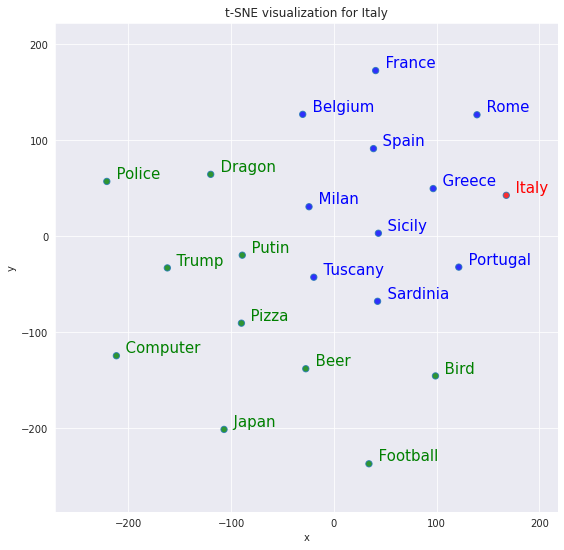

In [24]:
tsnescatterplot(model.wv, 'italy', ['beer', 'bird', 'police', 'trump', 'dragon', 'football', 'pizza', 'computer','putin','japan'])

10 most similar words from the model  compare to the 10 most dissimilar words



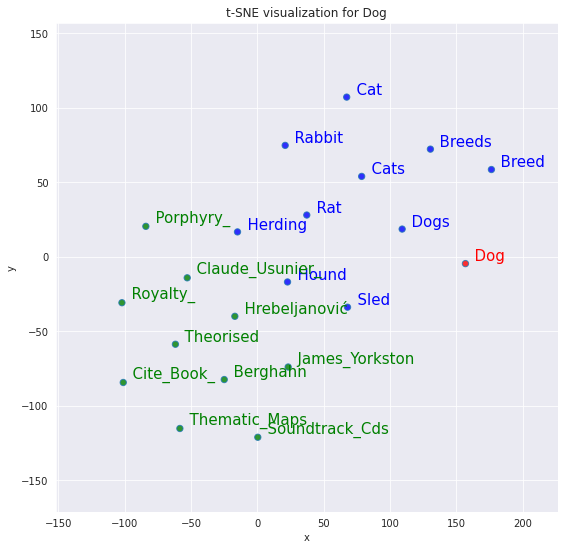

In [21]:
tsnescatterplot(model.wv, 'dog', [i[0] for i in model.wv.most_similar(negative=["basketball"])])

Number of words in the vocabulary:

In [22]:
len(model.wv.vocab)

538098

# Summary
I found that CBOW gave me slightly better results and was better than Skip-gram with the datasets I tried. As Accelerator I used  Negative Sampling because 
Hierarchical softmax just took too much time to run and the results were almost the same. I used google recommendations for window size, the dimensionality of word vectors regarding my corpus size, etc.
Running time was: 20 minutes

